In [1]:
import xlrd
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import ExcelFile
from sklearn.cluster import KMeans
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

# Import Data

In [2]:
raw_dataset = pd.read_excel("../resources/dataset/preprocessedDataset.xlsx")

In [3]:
raw_dataset.head(2)

,id,reliabilty,popularity,polarity
0,798171734918786944,0,107,1
1,798027051198546048,5,539,0


In [4]:
ids = raw_dataset.as_matrix(columns=raw_dataset.columns[:1])
X = raw_dataset.as_matrix(columns=raw_dataset.columns[1:])

print ids[:2]
print X[:2]

[[798171734918786944]
 [798027051198546048]]
[[  0 107   1]
 [  5 539   0]]


# Outlier Removal

In [5]:
def outlier_removal_v1(ids, X):
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(preprocessing.scale(X.astype('float64')))
    y = kmeans.labels_
    
    bincount_y = np.bincount(y)
    # print 'bincount(y):', bincount_y#, '\n'
    
    no_outlier_ids = []
    no_outlier_X = []
    
    min_population = +1e9
    less_populated_cluster = 0
    for i in range(0, len(bincount_y)):
        if bincount_y[i] < min_population:
            min_population = bincount_y[i]
            less_populated_cluster = i
        
    
    for i in range(len(y)):
        if y[i] != less_populated_cluster:
            no_outlier_ids.append(ids[i])
            no_outlier_X.append(X[i])

    no_outlier_ids = np.asarray(no_outlier_ids)
    no_outlier_X = np.asarray(no_outlier_X)

    # print 'len(ids):', len(no_outlier_ids)
    # print 'len(X):', len(no_outlier_X)
    # print '-----------------------------------------------'
    
    return np.asarray(no_outlier_ids), np.asarray(no_outlier_X)

In [6]:
def outlier_removal_v2(ids, X):
    from sklearn.ensemble import IsolationForest
    
    estimate = IsolationForest(max_samples=len(X),
                                        contamination=0.20,
                                        random_state=np.random.RandomState(42))
    estimate.fit(X)
    y = estimate.predict(X)
    print y
    
    import collections
    bincount_y = collections.Counter(y)
    # print 'bincount(y):', bincount_y, '\n'
    
    no_outlier_ids = []
    no_outlier_X = []
    
    for i in range(len(y)):
        if y[i] == +1:
            no_outlier_ids.append(ids[i])
            no_outlier_X.append(X[i])

    no_outlier_ids = np.asarray(no_outlier_ids)
    no_outlier_X = np.asarray(no_outlier_X)

    # print 'len(ids):', len(no_outlier_ids)
    print 'data size:', len(no_outlier_X)
    print '-----------------------------------------------'
    
    return np.asarray(no_outlier_ids), np.asarray(no_outlier_X)

In [7]:
for i in range(0, 15):
    ids, X = outlier_removal_v1(ids, X)
    
# ids, X = outlier_removal_v2(ids, X)

In [8]:
import collections
bincount = collections.Counter(X[:,0])

In [9]:
# bincount

# Kmeans Model and Silhouette Index

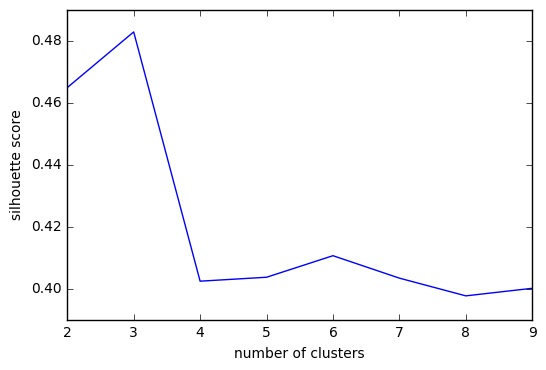

In [10]:
from sklearn.metrics import silhouette_score

sil_x = []
sil_y = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(preprocessing.scale(X.astype('float64')))
    y = kmeans.labels_
    
    sil_x.append(n_clusters)
    sil_y.append(silhouette_score(preprocessing.scale(X.astype('float64')), y, sample_size=len(X)))

    bincount_y = np.bincount(y)
    # print 'n_clusters', n_clusters, 'bincount(y):', bincount_y

plt.plot(sil_x, sil_y)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()

In [11]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(preprocessing.scale(X.astype('float64')))
y = kmeans.labels_

bincount_y = np.bincount(y)
print 'n_clusters', n_clusters, 'bincount(y):', bincount_y

n_clusters 3 bincount(y): [517  43  68]


In [12]:
table = pd.DataFrame(index=range(0, n_clusters), columns=['Segment', 'Count', 
                              'Mean_of_Reliability', 'Range_of_Reliability',
                              'Mean_of_Popularity', 'Range_of_Popularity',
                              'Mean_of_Polarity', 'Range_of_Polarity'])

In [13]:
for c in range(0, n_clusters):
    
    cnt = 0
    sum_rl, min_rl, max_rl = 0.0, +1e9, -1e9
    sum_pp, min_pp, max_pp = 0.0, +1e9, -1e9
    sum_pl, min_pl, max_pl = 0.0, +1e9, -1e9
    # print 'C' + str(c), '==============='
    for i in range(0, len(X)):
        if y[i] == c:
            # print i, X[i][0], X[i][1], X[i][2], y[i]
            
            cnt += 1
            
            sum_rl += X[i][0]
            min_rl = min(min_rl, X[i][0]) 
            max_rl = max(max_rl, X[i][0])

            sum_pp += X[i][1]
            min_pp = min(min_pp, X[i][1])
            max_pp = max(max_pp, X[i][1])
            
            sum_pl += X[i][2]
            min_pl = min(min_pl, X[i][2])
            max_pl = max(max_pl, X[i][2])
            
    table.Segment[c] = 'C' + str(c)
    table.Count[c] = cnt
    
    table.Mean_of_Reliability[c] = '%d' % (sum_rl / cnt)
    table.Range_of_Reliability[c] = '[%9d    %9d]' % (min_rl, max_rl)
    
    table.Mean_of_Popularity[c] = '%d' %(sum_pp / cnt)
    table.Range_of_Popularity[c] = '[%9d    %9d]' % (min_pp, max_pp)
    
    table.Mean_of_Polarity[c] = '%d' % (sum_pl / cnt)
    table.Range_of_Polarity[c] = '[%9d    %9d]' % (min_pl, max_pl)

In [14]:
table

,Segment,Count,Mean_of_Reliability,Range_of_Reliability,Mean_of_Popularity,Range_of_Popularity,Mean_of_Polarity,Range_of_Polarity
0,C0,517,1,[ 0 7],187,[ 0 716],0,[ -5 3]
1,C1,43,12,[ 6 25],356,[ 22 1895],0,[ -3 1]
2,C2,68,1,[ 0 9],1206,[ 716 1875],0,[ -2 4]


In [15]:
import collections
bincount_y = collections.Counter(X[:,1])

# Visualizations

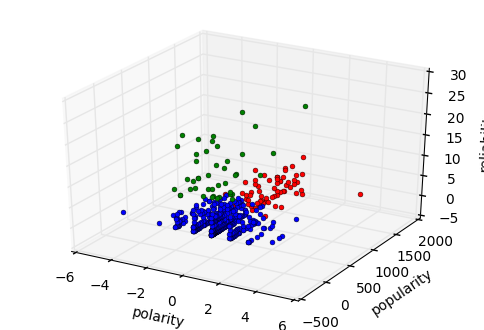

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'g', 'r', 'y']

for i in range(0, len(y)):
    ax.scatter(X[i,2], X[i,1], X[i,0], c=colors[y[i]], marker='.', s=50, linewidth=0.3)

ax.set_xlabel('polarity')
ax.set_ylabel('popularity')
ax.set_zlabel('reliability')

plt.show()

In [17]:
style.use('ggplot')

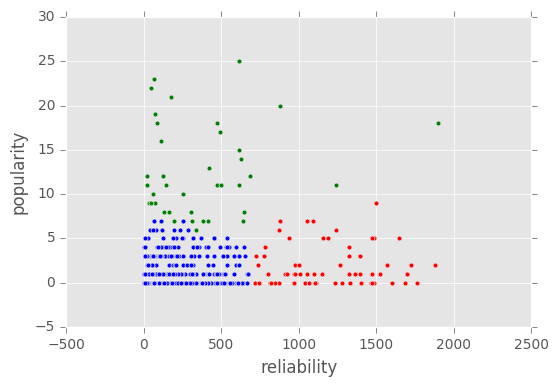

In [18]:
for i in range(0, len(y)):
    plt.scatter(X[i,1], X[i,0], c=colors[y[i]], marker='.', s=50)
plt.xlabel('reliability')
plt.ylabel('popularity')
plt.show()

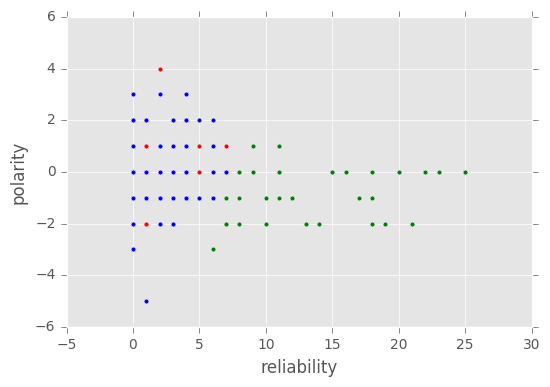

In [19]:
for i in range(0, len(y)):
    plt.scatter(X[i,0], X[i,2], c=colors[y[i]], marker='.', s=50)

plt.xlabel('reliability')
plt.ylabel('polarity')
plt.show()

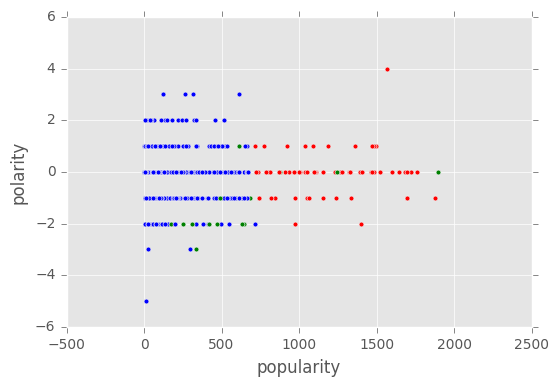

In [20]:
for i in range(0, len(y)):
    plt.scatter(X[i,1], X[i,2], c=colors[y[i]], marker='.', s=50)
plt.xlabel('popularity')
plt.ylabel('polarity')
plt.show()

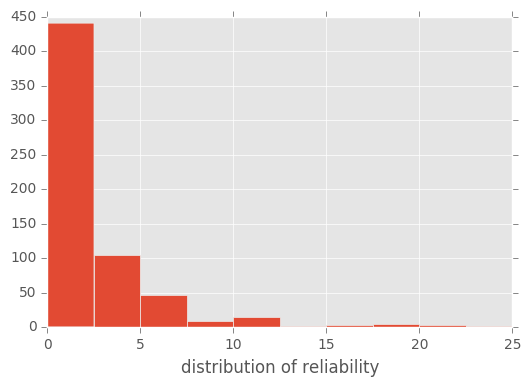

In [21]:
plt.hist(X[:,0])
plt.xlabel('distribution of reliability')
plt.show()

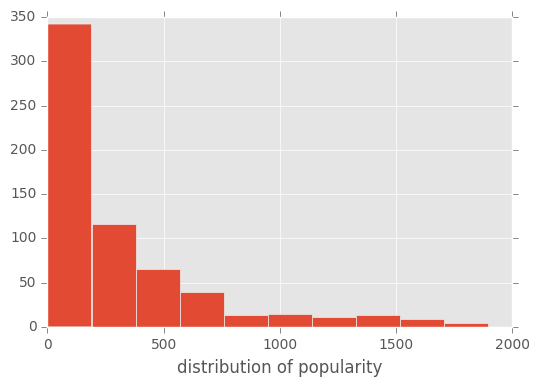

In [22]:
plt.hist(X[:,1])
plt.xlabel('distribution of popularity')
plt.show()

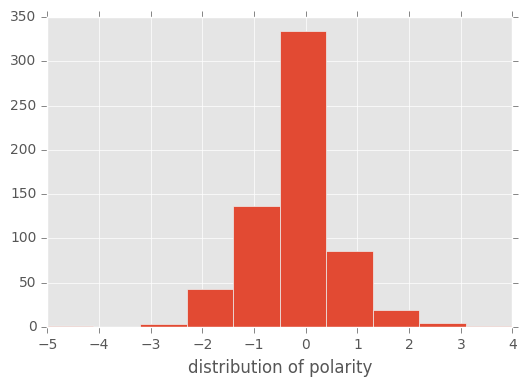

In [23]:
plt.hist(X[:,2])
plt.xlabel('distribution of polarity')
plt.show()